# DST-10_Project3_Arcis_Predict TripAdvisor Rating
В данном проекте нам предстоит предсказать рейтинг ресторана в TripAdvisor


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from datetime import datetime, timedelta, date, time # для работы с датами отзывов
import re # для работы с датами отзывов

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


# DATA

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Restaurant_id

Идентификатор ресторана. Не интересен с точки зрения обучения модели. Пропусков нет.

# City

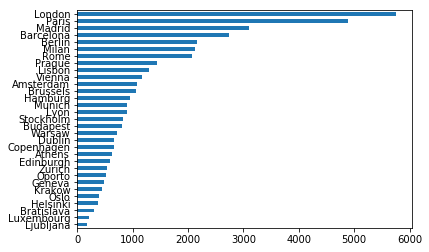

In [4]:
df_train['City'].value_counts(dropna = False, ascending=True).plot(kind='barh')

In [5]:
train_city = set(df_train['City'].value_counts().index)
test_city = set(df_test['City'].value_counts().index)
test_city - train_city

set()

**В тестовом наборе данных содержатся те же города что и в обучающей выборке**

Давайте найдём квантили 0.9 и 0.1 для рейтинга по каждому городу и добавим эту информацию в соотвествующие столбцы.

In [6]:
def city_rating_quantile_mean(df):
    
    quantile_09 = df_train.groupby(['City'])['Rating'].quantile(0.9)
    quantile_01 = df_train.groupby(['City'])['Rating'].quantile(0.1)
    mean_city = df_train.groupby(['City'])['Rating'].mean()
    
    df['city_rating_quantile_09'] = df['City'].apply(lambda x: quantile_09[x])
    df['city_rating_quantile_01'] = df['City'].apply(lambda x: quantile_01[x])
    df['city_rating_mean'] = df['City'].apply(lambda x: mean_city[x])
    
    return None    

In [7]:
def city_dummies(df):
    df['City2'] = df['City']
   
    return pd.get_dummies(df, columns=[ 'City2',], dummy_na=True)

Добавим информацию о том является ли город столицей (бинарный признак)

In [8]:
def capital_check(df):
    not_capital_list = ['Barcelona', 'Milan', 'Hamburg',
                        'Munich', 'Lyon', 'Zurich',
                        'Oporto', 'Geneva', 'Krakow']
    df['city_is_capital'] = df['City'].apply(lambda x: False if x in not_capital_list else True)
    return None

Добавим информацию о численности населения данного города. Данную информацию возьмём из открытых источников.

In [9]:
city_population = {
    'London': 8173900, 'Paris': 2240621, 'Madrid': 3155360,
    'Barcelona': 1593075, 'Berlin': 3326002, 'Milan': 1331586,
    'Rome': 2870493, 'Prague': 1272690, 'Lisbon': 547733,
    'Vienna': 1765649, 'Amsterdam': 825080, 'Brussels': 144784,
    'Hamburg': 1718187, 'Munich': 1364920, 'Lyon': 496343,
    'Stockholm': 1981263, 'Budapest': 1744665, 'Warsaw': 1720398,
    'Dublin': 506211, 'Copenhagen': 1246611, 'Athens': 3168846,
    'Edinburgh': 476100, 'Zurich': 402275, 'Oporto': 221800,
    'Geneva': 196150, 'Krakow': 756183, 'Oslo': 673469,
    'Helsinki': 574579, 'Bratislava': 413192, 'Luxembourg': 576249,
    'Ljubljana': 277554
}

In [10]:
df['Population'] = df['City'].map(city_population)

Добавим информацию по странам для каждого города. Информацию также возьмём из открытых источников.

In [11]:
city_country = {
    'London': 'UK', 'Paris': 'France', 'Madrid': 'Spain',
    'Barcelona': 'Spain', 'Berlin': 'Germany', 'Milan': 'Italy',
    'Rome': 'Italy', 'Prague': 'Czech', 'Lisbon': 'Portugalia',
    'Vienna': 'Austria', 'Amsterdam': 'Nederlands', 'Brussels': 'Belgium',
    'Hamburg': 'Germany', 'Munich': 'Germany', 'Lyon': 'France',
    'Stockholm': 'Sweden', 'Budapest': 'Hungary', 'Warsaw': 'Poland',
    'Dublin': 'Ireland', 'Copenhagen': 'Denmark', 'Athens': 'Greece',
    'Edinburgh': 'Schotland', 'Zurich': 'Switzerland', 'Oporto': 'Portugalia',
    'Geneva': 'Switzerland', 'Krakow': 'Poland', 'Oslo': 'Norway',
    'Helsinki': 'Finland', 'Bratislava': 'Slovakia', 'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

## Команды для Preprocessing


In [12]:
city_rating_quantile_mean(df)
df = city_dummies(df)
capital_check(df)
df['Population'] = df['City'].map(city_population)

df['Country'] = df['City'].map(city_country)
countries_le = LabelEncoder()
countries_le.fit(df['Country'])
df['country_code'] = countries_le.transform(df['Country'])
df = pd.get_dummies(df, columns=[ 'Country',], dummy_na=True)

## Резюме по параметру City: 
- категориальный признак
- пропусков нет
- параметр перекодирован по типу dummies
- сгенерированы новые признаки в связке с rating:
    - city_rating_quantile_09
    - city_rating_quantile_01
    - city_rating_mean
    - city_is_capital

# Cuisine Style

In [13]:
df['Cuisine Style'][0]

"['Bar', 'Pub']"

Тут явно требуется предобработка для того чтобы список кухонь стал именно списком. Вернёмся к этому чуть позже

In [14]:
pd.isna(df['Cuisine Style']).sum()/50000

0.2318

Более 23% пропусков, давайте закодируем их в отдельный признак

In [15]:
def cuisine_style_nans(df):
    df['cuisine_style_nans'] = pd.isna(df['Cuisine Style']).astype('uint8')
    return None

In [16]:
def cuisine_list(x):
    if type(x) is str:
        return x.strip("[]").replace("'", '').split(', ')
    else:
        return ['other'] # Заменим пустые списки на отдельный тип кухни - 'other'

In [17]:
def cuisine_count():
    cuisine_dict = {}
    for row in df['Cuisine Style']:
            if len(row) > 0:
                for i, v in enumerate(row):
                    cuisine_dict.setdefault(row[i], 0)
                    cuisine_dict[row[i]]+=1
    df_cuisine_style = pd.DataFrame.from_dict(cuisine_dict, orient='index', columns = ['count'])
    df_cuisine_style.sort_values(by='count', ascending=False, inplace = True)
    df_cuisine_style.reset_index(inplace = True)
    df_cuisine_style.columns = ['cuisine', 'count']
    
    return df_cuisine_style # возвращаем датафрейм с кухнями и их количеством по всем ресторанам

Пока оставим эту информацию для разработки инсайтов позже

## Команды для Preprocessing

In [18]:
cuisine_style_nans(df) # генерация нового признака - кол.-во пропусков
df['Cuisine Style'] = df['Cuisine Style'].apply(cuisine_list) # преобразование в списки
df['count_cuisine_style'] = df['Cuisine Style'].apply(lambda x: len(x)).astype('uint8') # ген. нового признака   


## Резюме по параметру Cuisine Style

- категориальный признак
- пропусков нет
- параметр перекодирован по типу dummies
- сгенерированы следующие параметры:
    - count_cuisine_style - количество кухонь в ресторане
    - cuisine_style_nans - индикатор отстуствия информации по кухням

# Ranking

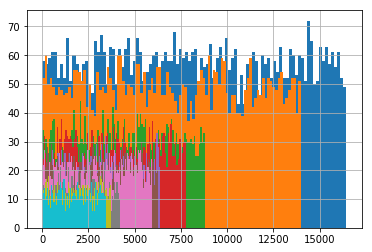

In [19]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

Очевидно, что данный параметр напрямую зависит от количества ресторанов в городе. Чтобы этот параметр можно было соотносить с ranking в других города этот параметр нужно нормировать.

In [20]:
def norm_Ranking(df):
    # найдём для каждого города максимальный и средний Ranking
    max_ranking_on_city = df.groupby(['City'])['Ranking'].max() 
    mean_ranking_on_city = df.groupby(['City'])['Ranking'].mean()
    std_ranking_on_city = df.groupby(['City'])['Ranking'].std()
    
    # в каждой строке пропишем соотвествующее значение максимального и среднего Ranking
    df['max_ranking_on_city'] = df['City'].apply(lambda x: max_ranking_on_city[x])
    df['mean_ranking_on_city'] = df['City'].apply(lambda x: mean_ranking_on_city[x])
    
    
    df['std_restorant_in_city'] = df['City'].apply(lambda x: std_ranking_on_city[x])
    
    df['norm_ranking_min_max'] = df['Ranking'] / df['max_ranking_on_city']
    df['norm_ranking_std'] = (df['Ranking'] - df['mean_ranking_on_city']) / df['std_restorant_in_city']
    return None

## Команды для Preprocessing

In [21]:
norm_Ranking(df)

## Резюме по параметру Ranking

- числовой признак (выражен натуральными числами)
- пропусков нет
- сгенерированы признаки:
    - нормализованные параметры ranking (minmax и std)
    - max_ranking_on_city - количество ресторанов в городе
    - mean_ranking_on_city - средний рейтинг в городе
    - std_restorant_in_city - стандартное отклонение в рейтинга в городе
    

# Price Range

In [22]:
df['Price Range'].value_counts(dropna = False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Оценка стоимости среднего чека может быть заменена на числа: 1, 2, 3.

Пропуски заменим пока средним значением - 2. 

In [23]:
def price_range(df):
    df['price_range_nans'] = pd.isna(df['Price Range']).astype('uint8')
    df['Price Range'].fillna(2, inplace = True)
    df['Price Range'].replace(['$', '$$ - $$$', '$$$$'], [1, 2, 3], inplace = True)
    return df['Price Range']

## Команды для Preprocessing

In [24]:
df['Price Range'] = price_range(df)

## Резюме по параметру Price Range

- изначально категориальный признак (заменили на числовой - уровень стоимости среднего чека)
- очень много пропусков - почти 35%
- пропуски вынесены в отдельный параметр
- пропуски заменены на моду - 2
- значения параметра заменены на числа: 1, 2, 3

# Number of Reviews

В данном параметре есть пропуски - окло 6%. Сохраним эту информаци в виде отдельного признака.
А пропуски заполним нулями

## Команды для Preprocessing

In [25]:
df['number_of_reviews_nans'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['Number of Reviews'].fillna(0, inplace=True)

## Резюме по параметру Number of Reviews

# Reviews

In [26]:
df['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [27]:
pd.isna(df['Reviews']).sum()

2

In [28]:
df['Reviews'][(df['Reviews'] == '[[], []]')].count()

8112

Приведём все пропуски данных к единой форме и по традиции выведем это в отдельный признак.

In [29]:
df['Reviews'].fillna('[[], []]', inplace = True)
df['reviews_nans'] = (df['Reviews']=='[[], []]').astype('uint8')

Поработаем с датами отзывов. Для начала вытащим их в отдельный столбец

In [30]:
df['review_dates'] = df['Reviews'].str.findall('\d+/\d+/\d+')

In [31]:
def list_data_f(s):
    pattern = re.compile('\d\d/\d\d/\d\d\d\d')
    list_dates = []
    if len(s) < 9:
        return datetime(2016, 1, 1).day - datetime(2016, 1, 2).day
    else:
        list_date = pattern.findall(s)       
        list_dates.extend([datetime.strptime(x, '%m/%d/%Y') for x in list_date])
        if len(list_dates) == 2:
            return abs(list_dates[0].day - list_dates[1].day)
        else:
            return datetime(2016, 1, 1).day - datetime(2016, 1, 1).day

In [32]:
df['Time_delta'] = df.Reviews.apply(list_data_f)

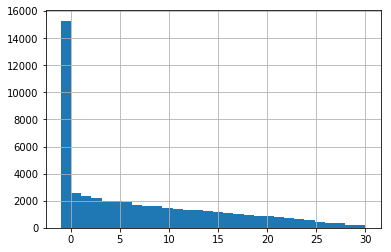

In [33]:
df['Time_delta'].hist(bins = 30)

## Команды для Preprocessing

In [34]:
df['Reviews'].fillna('[[], []]', inplace = True)
df['reviews_nans'] = (df['Reviews']=='[[], []]').astype('uint8')
df['Time_delta'] = df.Reviews.apply(list_data_f)

## Резюме по параметру Reviews

# URL_TA

Адрес странички рестарана на сайте TripAdvisor.
Не думаю, что тут есть полезные для нас данные.

# ID_TA

Очередной идентификатор, также не является полезным для нас.

# Rating - целевая переменная

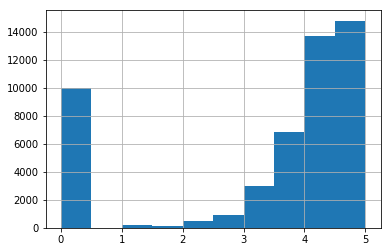

In [35]:
df['Rating'].hist()

0 - это тестовая часть данных (их ровно 10 000)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [36]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [37]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    df = df_input.copy()
    k0 = len(df.columns)
    print(k0, 'число параметров в исходном датасете')
    ### ПРЕДОБРАБОТКА И СОЗДАНИЕ НОВЫХ ПАРАМЕТРОВ ###
    
       #-->  1. Сity  <--#
    print('####################### Обработка параметра "City"')    
    city_rating_quantile_mean(df)
    df = city_dummies(df)
    capital_check(df)
    
    df['Country'] = df['City'].map(city_country)
    countries_le = LabelEncoder()
    countries_le.fit(df['Country'])
    df['country_code'] = countries_le.transform(df['Country'])
    df = pd.get_dummies(df, columns=['Country',], dummy_na=True)
    
    ki = len(df.columns)
    print(ki-k0, 'добавлено параметров в датасет')
       
        #--> 2. Cuisine Style <--#
    print('####################### Обработка параметра "Cuisine Style"')
    cuisine_style_nans(df) # генерация нового признака - кол.-во пропусков
    df['Cuisine Style'] = df['Cuisine Style'].apply(cuisine_list) # преобразование в списки
    # ген. нового признака - количетво кухонь в ресторане
    df['count_cuisine_style'] = df['Cuisine Style'].apply(lambda x: len(x)).astype('uint8')
    print(len(df.columns)-ki, 'добавлено параметров в датасет')
    ki = len(df.columns)
       
        #--> 3. Ranking <--#
    print('####################### Обработка параметра "Ranking"')
    norm_Ranking(df)
    print(len(df.columns)-ki, 'добавлено параметров в датасет')
    ki = len(df.columns)
       
        #--> 4. Price Range <--#
    print('####################### Обработка параметра "Price Range"')    
    df['Price Range'] = price_range(df)
    print(len(df.columns)-ki, 'добавлено параметров в датасет')
    ki = len(df.columns)    
       
        #--> 5. Number of Reviews <--#
    print('####################### Обработка параметра "Number of Reviews"')
    df['number_of_reviews_nans'] = pd.isna(df['Number of Reviews']).astype('uint8')
    df['Number of Reviews'].fillna(0, inplace=True)
    print(len(df.columns)-ki, 'добавлено параметров в датасет')
    ki = len(df.columns)
       
        #--> 6. Reviews <--#
    print('####################### Обработка параметра "Reviews"')   
    df['Reviews'].fillna('[[], []]', inplace = True)
    df['reviews_nans'] = (df['Reviews']=='[[], []]').astype('uint8')
    df['Time_delta'] = df.Reviews.apply(list_data_f)
    print(len(df.columns)-ki, 'добавлено параметров в датасет')
    ki = len(df.columns)   
        
        #-->  <--#
    
    ### УДАЛЯЕМ ВСЕ НЕЧИСЛОВЫЕ ПАРАМЕТРЫ ###
    
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df.columns if df[s].dtypes == 'object']
    df.drop(object_columns, axis = 1, inplace=True)
    
    print('Удалили эти столбцы -> ', object_columns)

    return df

df_preproc = preproc_data(data)
df_preproc.info()

11 число параметров в исходном датасете
####################### Обработка параметра "City"
61 добавлено параметров в датасет
####################### Обработка параметра "Cuisine Style"
2 добавлено параметров в датасет
####################### Обработка параметра "Ranking"
5 добавлено параметров в датасет
####################### Обработка параметра "Price Range"
1 добавлено параметров в датасет
####################### Обработка параметра "Number of Reviews"
1 добавлено параметров в датасет
####################### Обработка параметра "Reviews"
2 добавлено параметров в датасет
Удалили эти столбцы ->  ['Restaurant_id', 'City', 'Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 77 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating            

In [38]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

'''
Перед тем как отправлять наши данные на обучение, 
разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, 
до отправки submissiona на kaggle.
'''

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 76), (40000, 76), (40000, 75), (32000, 75), (8000, 75))

# Model 
Сам ML

In [39]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = np.around(y_pred/0.5, decimals=0, out=None)*0.5


# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


MAE: 0.174


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


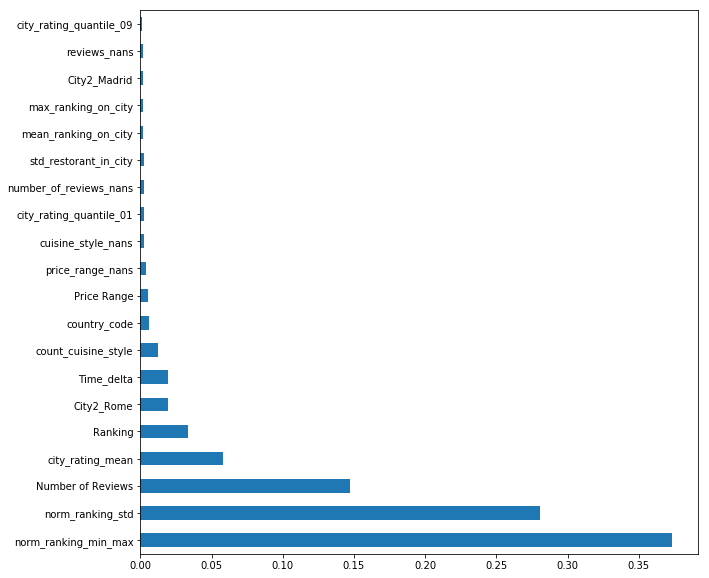

In [40]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [41]:
# Переобучим модель на всех данных
model.fit(X, y)

test_data = test_data.drop(['Rating'], axis=1)

predict_submission = model.predict(test_data)
predict_submission = np.around(predict_submission/0.5, decimals=0, out=None)*0.5

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [42]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4. , 4. ])

In [43]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.0
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
